In [9]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# TreeNode class definition
class TreeNode:
    def __init__(self, left=None, right=None, filenames=None, data=None):
        self.left = left
        self.right = right
        self.filenames = filenames
        self.data = data

# Load the tree
def load_tree(input_file):
    with open(input_file, 'rb') as f:
        return pickle.load(f)

tree = load_tree('fractal-embeddings-main\sample_data\combined_dendrogram.pkl')

# Load the data
embeddings = np.load('fractal-embeddings-main\sample_data\combined_reduced_embeddings.npz')
filenames = pd.read_csv('fractal-embeddings-main\sample_data\combined_filenames.csv', header=None).values.flatten()

In [2]:
# lists contents of embeddings
embeddings.files

['pca5', 'tsne2', 'umap5', 'umap2']

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyvista as pv
from shapely import Point, MultiPoint, box, voronoi_polygons, convex_hull
import matplotlib.colors as mcolors
from pyvista import examples

def gdf_to_mesh(gdf, labels, cluster_color):
    
    gdf['area'] = gdf['geometry'].area
    gdf = gdf.sort_values('area').reset_index(drop=True)
    
    vertices = []
    faces = []
    
    poly_ids = []
    face_labels = []
    face_colors = []

    for index, row in gdf.iterrows():
        polygon = row['geometry']
        if not polygon.is_valid:
            continue

        exterior = np.array(polygon.exterior.coords)
        exterior_3d = np.hstack([exterior, np.zeros((len(exterior), 1))])  # Add z-coordinate of zero
        vertices.append(exterior_3d)

        face = np.arange(len(exterior), dtype=np.int64) + len(np.vstack(vertices)[:-len(exterior)])
        faces.append(face)

        # Assign an ID to each polygon
        poly_ids.extend([index] * len(face))

        
        face_label = labels[index]
        face_labels.append(face_label)

        face_color = cluster_color #[index]
        #face_color = mcolors.to_hex(rgb[index])
        face_colors.append(face_color)

    # Combine vertices and face connectivity lists
    vertices = np.vstack(vertices)
    faces = np.hstack([np.hstack([[len(face)], face]) for face in faces])

    mesh = pv.PolyData(vertices, faces)

    labels_encoded = [s.encode('utf-8') for s in face_labels]

    # Add polygon IDs and face labels as scalar arrays
    mesh["PolyIDs"] = -np.array(poly_ids) # added a negative sign to flip the poly id's
    mesh["FaceLabels"] = labels_encoded    
    mesh["FaceColors"] = face_colors

    return mesh

def create_voronoi_gdf(polygons, edges):
    voronoi_polygons = []

    for i, polygon in enumerate(polygons.geoms):
        clipped_polygon = polygon.intersection(edges)
        voronoi_polygons.append(clipped_polygon)

    gdf = gpd.GeoDataFrame(geometry=voronoi_polygons)
    return gdf


def get_rgb(color_string):
    # get the RGB color values
    rgb = mcolors.to_rgb(color_string)
    
    # convert the values to 0-255 range
    rgb = tuple([int(x*255) for x in rgb])
    return rgb



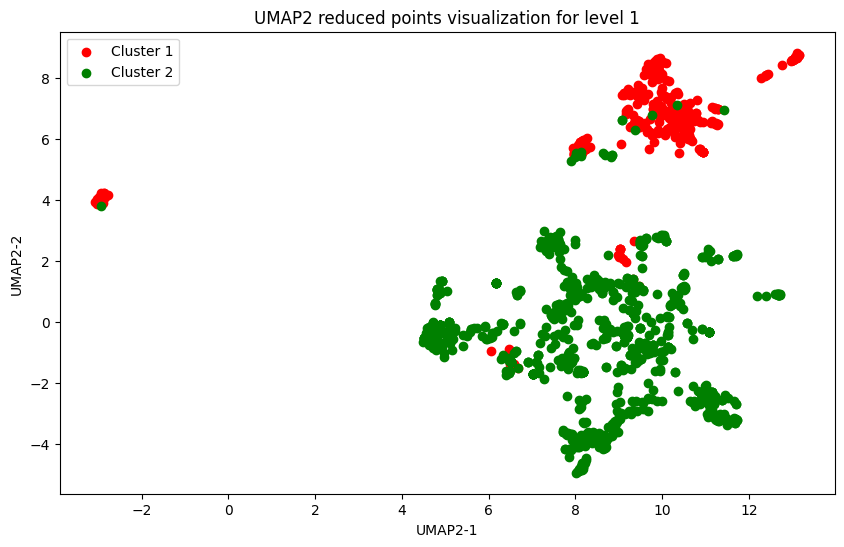

Widget(value="<iframe src='http://localhost:52861/index.html?ui=P_0x212640c6650_12&reconnect=auto' style='widt…

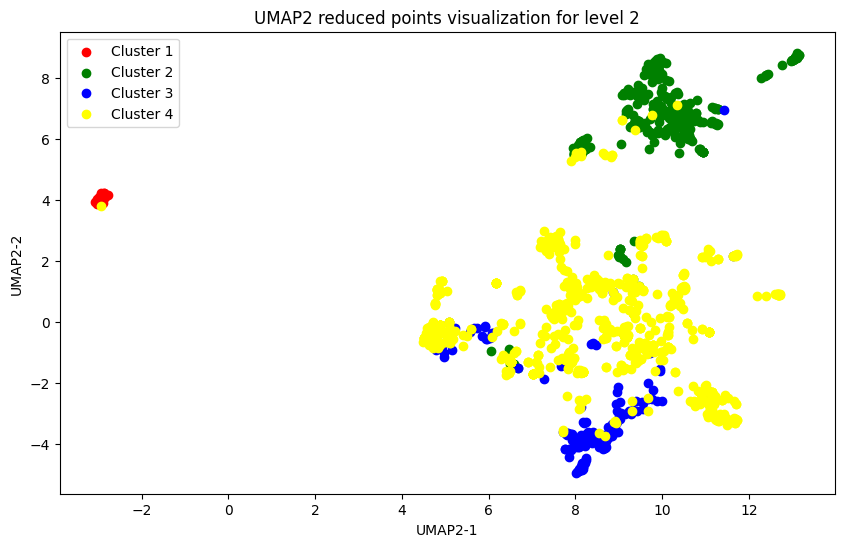

Widget(value="<iframe src='http://localhost:52861/index.html?ui=P_0x2126407b730_13&reconnect=auto' style='widt…

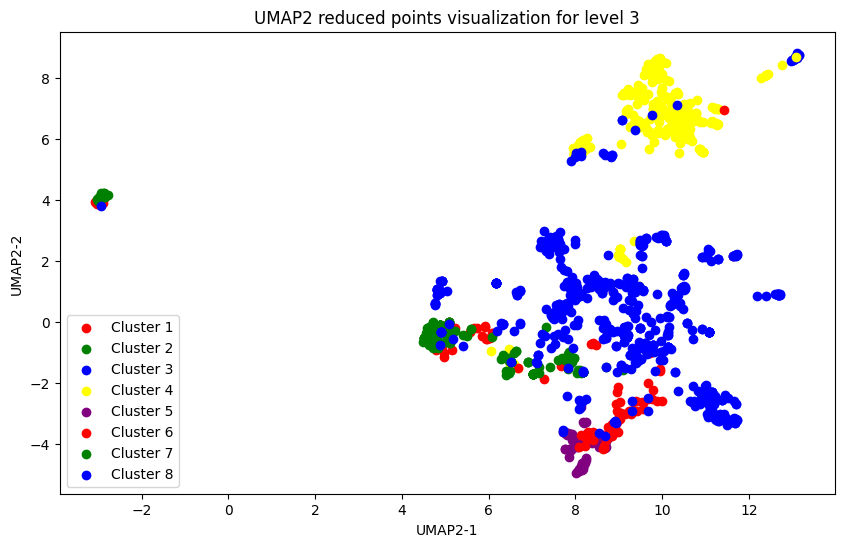

Widget(value="<iframe src='http://localhost:52861/index.html?ui=P_0x2128680ca30_14&reconnect=auto' style='widt…

In [11]:

def get_clusters(tree, level):
    if tree.left is None and tree.right is None:
        return tree.filenames
    
    if level == 1:
        return tree.left.filenames, tree.right.filenames
    
    return get_clusters(tree.left, level - 1) + get_clusters(tree.right, level - 1)

def visualize_clusters(tree, level, points):
    
    clusters = get_clusters(tree, level)
    meshs = list()
    colors = ["red", "green", "blue", "yellow", "purple"]
    plt.figure(figsize=(10, 6))
    
    for i, cluster in enumerate(clusters):
        indices = [np.where(filenames == fname)[0][0] for fname in cluster]

        color = colors[i % len(colors)]  # Get the color for this cluster
        
        plt.scatter(points[indices, 0], points[indices, 1], color=color, label=f"Cluster {i + 1}")
        
        # get the cluster points as shaply Point obj
        cluster_points = [Point(x, y) for x, y in points[indices]]
            
        cluster_points_shaply_obj = MultiPoint(cluster_points)
        hull = MultiPoint(cluster_points).convex_hull
        
        polygons = voronoi_polygons(cluster_points_shaply_obj)
        cluster_color = get_rgb(color)
        
        gdf = create_voronoi_gdf(polygons, hull)

        mesh = gdf_to_mesh(gdf, filenames, cluster_color)
        
        meshs.append(mesh)   
        
       
    plt.legend()
    plt.title(f"UMAP2 reduced points visualization for level {level}")
    plt.xlabel("UMAP2-1")
    plt.ylabel("UMAP2-2")
    plt.show()


    pl = pv.Plotter()
    translation_ratio = 0.00
    for mesh in meshs:
        mesh = mesh.translate((0, 0, translation_ratio), inplace=False)
        
        #pl.add_mesh(mesh, scalars='FaceColors',  show_edges=True)
        pl.add_mesh(mesh, scalars = 'PolyIDs',  show_edges=True)
        
        centers = mesh.cell_centers()
        
        warp = mesh.warp_by_scalar(factor=0.0009) 
        surf = warp.delaunay_2d(alpha=3.5)
        smooth = surf.smooth(n_iter=100)
        
        # for polygon labels  
        #pl.add_points(centers, render_points_as_spheres=True, color='red', point_size=2)
        #pl.add_point_labels(centers, "FaceLabels",  point_size=5, font_size=10)
       
        
        translation_ratio+= 1 # change to a higher number for Pca5 

    pl.show()




pca5_points = embeddings['pca5'][:, 3:5]
umap2_points = embeddings['umap2']
#umap5_points = embeddings['umap5'] 
tsne2_points = embeddings['tsne2']

for level in range(1, 4):
    visualize_clusters(tree, level, umap2_points)


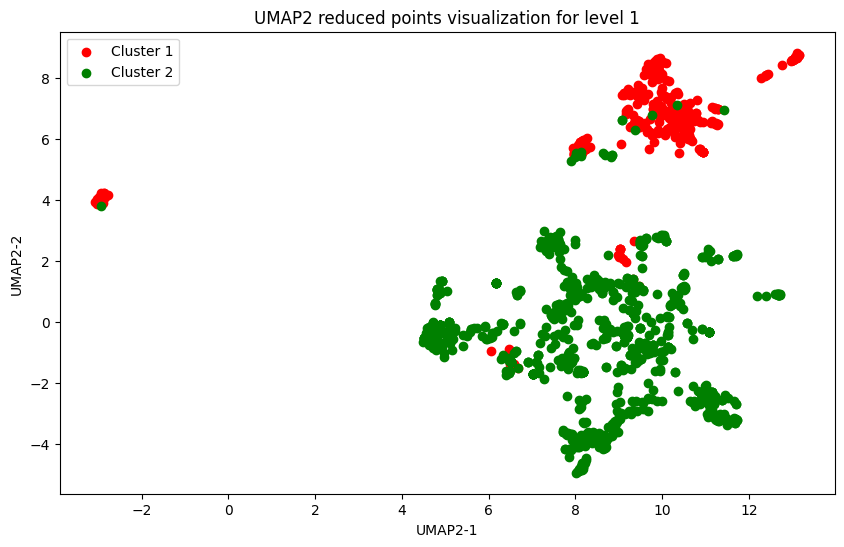

Widget(value="<iframe src='http://localhost:52861/index.html?ui=P_0x212dae2fe50_15&reconnect=auto' style='widt…

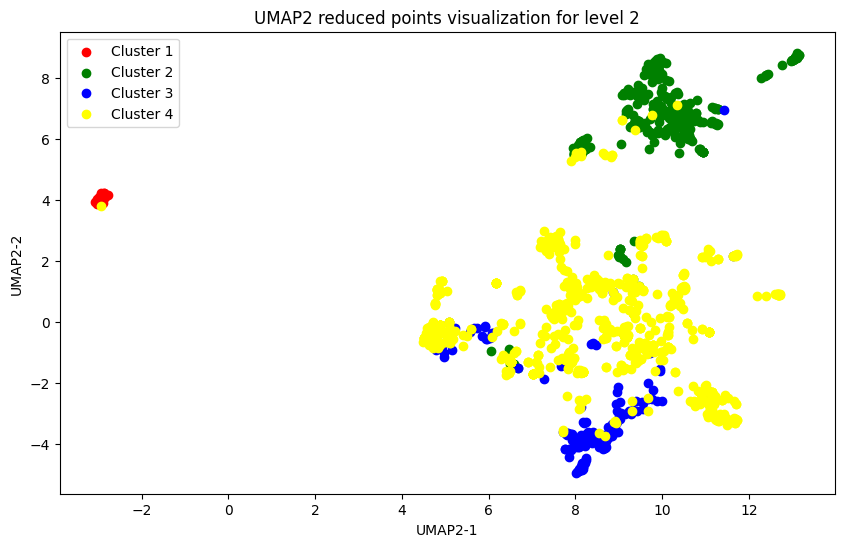

Widget(value="<iframe src='http://localhost:52861/index.html?ui=P_0x212bbc97dc0_16&reconnect=auto' style='widt…

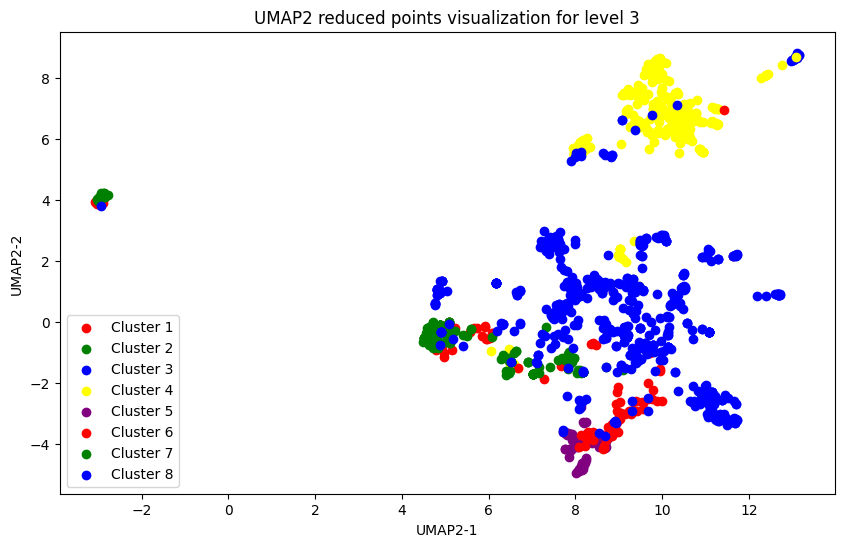

Widget(value="<iframe src='http://localhost:52861/index.html?ui=P_0x212bbc94880_17&reconnect=auto' style='widt…

In [12]:
def visualize_clusters(tree, level, points):
    clusters = get_clusters(tree, level)
    meshs = list()
    plt.figure(figsize=(10, 6))
    colors = ["red", "green", "blue", "yellow", "purple"]
    
    for i, cluster in enumerate(clusters):
        indices = [np.where(filenames == fname)[0][0] for fname in cluster]

        color = colors[i % len(colors)]  # Get the color for this cluster
        
        plt.scatter(points[indices, 0], points[indices, 1], color=color, label=f"Cluster {i + 1}")
        
        cluster_points = [Point(x, y) for x, y in points[indices]]
            
        cluster_points_shaply_obj = MultiPoint(cluster_points)
        hull = MultiPoint(cluster_points).convex_hull
        polygons = voronoi_polygons(cluster_points_shaply_obj)
        gdf = create_voronoi_gdf(polygons, hull)

        cluster_color = get_rgb(color)
        mesh = gdf_to_mesh(gdf, filenames, cluster_color)
        
        meshs.append(mesh)   
        
       
    plt.legend()
    plt.title(f"UMAP2 reduced points visualization for level {level}")
    plt.xlabel("UMAP2-1")
    plt.ylabel("UMAP2-2")
    plt.show()

    pl = pv.Plotter()
    
    image_path = examples.planets.download_milkyway_sky_background(load=False)
    pl.add_background_image(image_path)
    
    translation_ratio = 0.00
    for mesh in meshs:
        mesh = mesh.translate((0, 0, translation_ratio), inplace=False)
        
        #pl.add_mesh(mesh, scalars='FaceColors',  show_edges=True)
        #pl.add_mesh(mesh, scalars = 'PolyIDs',  show_edges=True)
        
        centers = mesh.cell_centers()
        
        warp = mesh.warp_by_scalar(factor=0.0009) #0.5e-5
        surf = warp.delaunay_2d(alpha=3.5)
        smooth = surf.smooth(n_iter=100)
        
        #pl.add_points(centers, render_points_as_spheres=True, color='red', point_size=2)
        #pl.add_point_labels(centers, "FaceLabels",  point_size=5, font_size=10)

        pl.add_mesh(smooth,  show_edges=False)

        #text_mesh = pv.Text3D("Mesh", depth=0.002)
        #text_mseh_scaled = text_mesh.scale([0.1, 0.1, 0.1], inplace=False)
        #pl.add_mesh(text_mseh_scaled)
       
        
        translation_ratio+= 3 #0.10

    pl.show()

    #return meshs


# ['pca5', 'tsne2', 'umap5', 'umap2']


pca5_points = embeddings['pca5'][:, 3:5]
umap2_points = embeddings['umap2']
#umap5_points = embeddings['umap5']
tsne2_points = embeddings['tsne2']

for level in range(1, 4):
    visualize_clusters(tree, level, umap2_points)